<a href="https://colab.research.google.com/github/BIJESHPATEL369/CSCE-5290-Natural-Language-Processing-Project/blob/main/Increment_2_Task_2_Muticlass_Product_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INCREMENT 2 :Task 2 : MULTICLASS PRODUCT CLASSIFICATION

# Install Packages

In [1]:
#NLTK package to dowload the stop words, import PorterStemmer.
!pip install nltk

#Tensor flow to downlad the Universel sentence encoder for embedding the text.
!pip install tensorflow_text 

# install tarnsformers
!pip install transformers

# install sentencepiece
!pip install sentencepiece

# To download dataset from google drive
!pip install gdown

     |████████████████████████████████| 4.9 MB 3.9 MB/s 
     |████████████████████████████████| 462 kB 67.9 MB/s 
     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 65.4 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 46.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


# Import Libraries

In [2]:
import pandas as pd
import re
import string 
import numpy as np
import time

# pre-processing the input features
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

# order the feature text for removing duplicates
from collections import OrderedDict

#convert the string text to vector representation
import tensorflow_hub as hub
import tensorflow_text
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# To create traning and test dataset
from sklearn.model_selection import train_test_split

# Shuffle data
from sklearn.utils import shuffle

# Loading the model
from sklearn.ensemble import RandomForestClassifier

# Evaluate the model accuaracy
from sklearn.metrics import accuracy_score, classification_report

# Ploting the data analyisis
import matplotlib.pyplot as plt

# data preparation
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import pickle
import os

# import training model requirments
from transformers import AlbertTokenizer, BertTokenizer, BertForSequenceClassification, AdamW, AlbertForSequenceClassification

# Evaluation report
from sklearn.metrics import classification_report

# device set up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
cuda:0


# Loading Data sets

Reading the Product catalog and train data datasets

In [3]:
!gdown --folder https://drive.google.com/drive/folders/1ezO5qJSDfzUd4V9FjYnAD3hCXCeTM2uh?usp=sharing 

Retrieving folder list
Processing file 1OSVaAdLldXYgbE28ySk3AZpYROTxinBl product_catalogue-v0.2.csv
Processing file 1BYNgwWuz_w-7CtCBzrlEUFiJ7DC0VyGB sample_submission-v0.2.csv
Processing file 14Zk3b7HQ-oICLkog0jYI6AGQdCPMFGGJ test_public-v0.2.csv
Processing file 1PV5DCqZS9KyOSdQNENjAu3rXb4bsko7K train-v0.2.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1OSVaAdLldXYgbE28ySk3AZpYROTxinBl
To: /content/Dataset csv/product_catalogue-v0.2.csv
100% 2.13G/2.13G [00:07<00:00, 286MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BYNgwWuz_w-7CtCBzrlEUFiJ7DC0VyGB
To: /content/Dataset csv/sample_submission-v0.2.csv
100% 7.00M/7.00M [00:00<00:00, 185MB/s]
Downloading...
From: https://drive.google.com/uc?id=14Zk3b7HQ-oICLkog0jYI6AGQdCPMFGGJ
To: /content/Dataset csv/test_public-v0.2.csv
100% 17.9M/17.9M [00:00<00:00, 114MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1PV5D

In [4]:
# Reading the Product catalog and train data datasets
product_catalog_pd = pd.read_csv('/content/Dataset csv/product_catalogue-v0.2.csv')
train_pd = pd.read_csv('/content/Dataset csv/train-v0.2.csv')
test_public_pd = pd.read_csv('/content/Dataset csv/test_public-v0.2.csv')
sample_submission_pd = pd.read_csv('/content/Dataset csv/sample_submission-v0.2.csv')

In [5]:
print(product_catalog_pd["product_locale"].unique())

# Select 'US' Locale from both train and product catalog dataset
us_product_catalog_pd = product_catalog_pd.loc[product_catalog_pd['product_locale'] == 'us']
us_train_pd = train_pd.loc[train_pd['query_locale'] == 'us']

['es' 'us' 'jp']


In [6]:
us_train_pd

,example_id,query,product_id,query_locale,esci_label
249721,249721,revent 80 cfm,B000MOO21W,us,irrelevant
249722,249722,revent 80 cfm,B001E6DMKY,us,exact
249723,249723,revent 80 cfm,B003O0MNGC,us,exact
249724,249724,revent 80 cfm,B00MARNO5Y,us,exact
249725,249725,revent 80 cfm,B00XBZFWWM,us,exact
...,...,...,...,...,...
1522342,1522342,zephyr polishing kit,B081SYK6R2,us,irrelevant
1522343,1522343,zephyr polishing kit,B087HZQY4V,us,complement
1522344,1522344,zephyr polishing kit,B08H4ZJ6Q1,us,substitute
1522345,1522345,zephyr polishing kit,B08LSN8MT8,us,substitute


In [7]:
us_test_public_pd = test_public_pd.loc[test_public_pd['query_locale'] == 'us']

In [8]:
us_test_public_pd

,example_id,query,product_id,query_locale
53494,2280865,#1 small corded treadmill without remote control,B00QIM5CMK,us
53495,2280866,#1 small corded treadmill without remote control,B0193V3DJ6,us
53496,2280867,#1 small corded treadmill without remote control,B07KTSR8MP,us
53497,2280868,#1 small corded treadmill without remote control,B07MW21KMZ,us
53498,2280869,#1 small corded treadmill without remote control,B07SJCZLPQ,us
...,...,...,...,...
327750,2555121,xl tall moisture wicking shirt,B08XX3NL14,us
327751,2555122,xl tall moisture wicking shirt,B08Y8M9Z6L,us
327752,2555123,xl tall moisture wicking shirt,B0936FKSS6,us
327753,2555124,xl tall moisture wicking shirt,B096RXY1VT,us


In [9]:
us_train_pd.esci_label.value_counts()

exact         874058
substitute    257735
irrelevant    112618
complement     28215
Name: esci_label, dtype: int64

# Data Description

**Product Catalog dataset**

In [10]:
us_product_catalog_pd.head(3)

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
167236,B003O0MNGC,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,NaN,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us
167237,B00MARNO5Y,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,NaN,Super quiet 80CFM energy efficient fan virtual...,Aero Pure,White,us
167238,B011RX6PNO,Aero Pure AP120H-SL W Slim Fit 120 CFM Bathroo...,NaN,"Slim Fit Housing Fits Into 2"" X 6"" Ceiling Joi...",Aero Pure,White Finish,us


**Train dataset**

In [11]:
us_train_pd.head(5)

,example_id,query,product_id,query_locale,esci_label
249721,249721,revent 80 cfm,B000MOO21W,us,irrelevant
249722,249722,revent 80 cfm,B001E6DMKY,us,exact
249723,249723,revent 80 cfm,B003O0MNGC,us,exact
249724,249724,revent 80 cfm,B00MARNO5Y,us,exact
249725,249725,revent 80 cfm,B00XBZFWWM,us,exact


**Product catalog and Train dataset info**

In [12]:
print("Product catalog: \n")
us_product_catalog_pd.info()
print("\n \n")
print("Train: \n")
us_train_pd.info()

Product catalog: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216070 entries, 167236 to 1753643
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   product_id            1216070 non-null  object
 1   product_title         1215854 non-null  object
 2   product_description   646076 non-null   object
 3   product_bullet_point  1037091 non-null  object
 4   product_brand         1143575 non-null  object
 5   product_color_name    809776 non-null   object
 6   product_locale        1216070 non-null  object
dtypes: object(7)
memory usage: 74.2+ MB

 

Train: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272626 entries, 249721 to 1522346
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   example_id    1272626 non-null  int64 
 1   query         1272626 non-null  object
 2   product_id    1272626 non-null  object
 3   

**Product catalog describe**

In [13]:
us_product_catalog_pd.describe(include='object')

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
count,1216070,1215854,646076,1037091,1143575,809776,1216070
unique,1216070,1193661,541651,861808,211177,175308,1
top,B003O0MNGC,Episode 1,This pre-owned or refurbished product has been...,Used Book in Good Condition,Nike,Black,us
freq,1,152,1192,2718,6160,125444,1216070


**Train dataset describe**

In [14]:
us_train_pd.describe(include='object')

,query,product_id,query_locale,esci_label
count,1272626,1272626,1272626,1272626
unique,68139,913438,1,4
top,tv,B01HFFXLNA,us,exact
freq,198,88,1272626,874058


# Design of features

In [15]:
# Join the product catalog and train dataset based on product id
us_train_product_df = us_train_pd.merge(us_product_catalog_pd,left_on = ['product_id'],right_on=['product_id'], how= 'left')

#Combine Product Catalog Text into one column
columns = ['product_title', 'product_brand', 'product_color_name']
us_train_product_df['product_text'] = us_train_product_df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Feature selection
us_train_product_modified_df = us_train_product_df[['example_id', 'query', 'product_id','esci_label', 'product_text']].copy()

In [16]:
# shuffle data
us_train_product_modified_df = shuffle(us_train_product_modified_df)

# data sampling
us_train_product_modified_sampe_df = us_train_product_modified_df.sample(n = 250000)

# Data Cleaning

**Apply Preprocessing**

In [17]:
stop_words = stopwords.words('english')
# Stemmer = PorterStemmer()
table = str.maketrans('', '', string.punctuation)

def data_cleaning(text):
  texts = re.sub("[^a-zA-Z]", " ", text)
  texts = [texts.lower() for texts in text.split() if texts.lower() not in stop_words]
  # texts = [Stemmer.stem(t) for t in texts]
  texts = [t.translate(table) for t in texts]
  return " ".join(texts)

# data cleaning
us_train_product_modified_sampe_df['query'] = us_train_product_modified_sampe_df['query'].apply(data_cleaning)
us_train_product_modified_sampe_df['product_text'] = us_train_product_modified_sampe_df['product_text'].apply(data_cleaning)

In [18]:
# remove duplicate words form product text
us_train_product_modified_sampe_df['product_text_modified'] = (us_train_product_modified_sampe_df['product_text'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))
us_train_product_modified_sampe_df

,example_id,query,product_id,esci_label,product_text,product_text_modified
993795,1243516,underjams,B07JM1NVCV,exact,item underjams bedtime underwear girls size sm...,item underjams bedtime underwear girls size sm...
1046503,1296224,winter weight blanket bed,B07QTJ3YPP,exact,dangtop cooling blankets queen size 100 bamboo...,dangtop cooling blankets queen size 100 bamboo...
282147,531868,daddy daugther dance dress girls,B019ARHYWA,exact,hk22 girls dress sequin mesh party wedding pri...,hk22 girls dress sequin mesh party wedding pri...
627203,876924,mens dress white socks,B07TXHDVLT,exact,wander mens solid dress socks cotton men 8 pai...,wander mens solid dress socks cotton men 8 pai...
695592,945313,nvidia graphics card,B01M25X363,substitute,gigabyte geforce gtx 1050 ti oc 4gb gddr5 128 ...,gigabyte geforce gtx 1050 ti oc 4gb gddr5 128 ...
...,...,...,...,...,...,...
1079202,1328923,youth boys crew socks,B00BI20EQO,exact,hanes boys 6pack ez short crew socks black med...,hanes boys 6pack ez short crew socks black med...
1173537,1423258,fire stick without alexa,B015UKRNGS,irrelevant,google chromecast streaming device hdmi cable...,google chromecast streaming device hdmi cable ...
211992,461713,cat jack shoe,B075V4SC26,substitute,kids canvas sneaker slipon baby boys girls cas...,kids canvas sneaker slipon baby boys girls cas...
137275,386996,big boys sneakers,B07JMTYFR8,exact,nike unisexchild star runner 2 gs sneaker anth...,nike unisexchild star runner 2 gs sneaker anth...


In [ ]:
#Check Null Values
us_train_product_modified_sampe_df.isnull().sum()

example_id               0
query                    0
product_id               0
esci_label               0
product_text             0
product_text_modified    0
dtype: int64

# Data visualization

**visualization of target variables**

In [19]:
us_train_product_modified_sampe_df.esci_label.value_counts()

exact         171299
substitute     50837
irrelevant     22326
complement      5538
Name: esci_label, dtype: int64

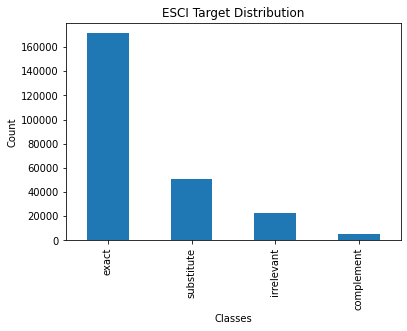

In [20]:
us_train_product_modified_sampe_df.esci_label.value_counts().plot(kind='bar', title='ESCI Target Distribution', xlabel= 'Classes', ylabel = 'Count')
plt.show()

In [21]:
us_train_product_modified_sampe_df['esci_label'].value_counts(normalize=True) * 100

exact         68.5196
substitute    20.3348
irrelevant     8.9304
complement     2.2152
Name: esci_label, dtype: float64

In [22]:
# create length feature for query, product text
us_train_product_modified_sampe_df['length_product_text'] = us_train_product_modified_sampe_df['product_text'].apply(len)
us_train_product_modified_sampe_df['length_query'] = us_train_product_modified_sampe_df['query'].apply(len)
us_train_product_modified_sampe_df['length_product_text_modified'] = us_train_product_modified_sampe_df['product_text_modified'].apply(len)

In [23]:
# checking for length of feature text to minimum 513
us_train_product_modified_sampe_df = us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.length_product_text < 513]
us_train_product_modified_sampe_df = us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.length_query < 513]
us_train_product_modified_sampe_df = us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.length_product_text_modified < 513]

In [24]:
us_train_product_modified_sampe_df

,example_id,query,product_id,esci_label,product_text,product_text_modified,length_product_text,length_query,length_product_text_modified
993795,1243516,underjams,B07JM1NVCV,exact,item underjams bedtime underwear girls size sm...,item underjams bedtime underwear girls size sm...,93,9,92
1046503,1296224,winter weight blanket bed,B07QTJ3YPP,exact,dangtop cooling blankets queen size 100 bamboo...,dangtop cooling blankets queen size 100 bamboo...,184,25,147
282147,531868,daddy daugther dance dress girls,B019ARHYWA,exact,hk22 girls dress sequin mesh party wedding pri...,hk22 girls dress sequin mesh party wedding pri...,88,32,83
627203,876924,mens dress white socks,B07TXHDVLT,exact,wander mens solid dress socks cotton men 8 pai...,wander mens solid dress socks cotton men 8 pai...,124,22,91
695592,945313,nvidia graphics card,B01M25X363,substitute,gigabyte geforce gtx 1050 ti oc 4gb gddr5 128 ...,gigabyte geforce gtx 1050 ti oc 4gb gddr5 128 ...,95,20,86
...,...,...,...,...,...,...,...,...,...
1079202,1328923,youth boys crew socks,B00BI20EQO,exact,hanes boys 6pack ez short crew socks black med...,hanes boys 6pack ez short crew socks black med...,65,21,53
1173537,1423258,fire stick without alexa,B015UKRNGS,irrelevant,google chromecast streaming device hdmi cable...,google chromecast streaming device hdmi cable ...,102,24,93
211992,461713,cat jack shoe,B075V4SC26,substitute,kids canvas sneaker slipon baby boys girls cas...,kids canvas sneaker slipon baby boys girls cas...,90,13,90
137275,386996,big boys sneakers,B07JMTYFR8,exact,nike unisexchild star runner 2 gs sneaker anth...,nike unisexchild star runner 2 gs sneaker anth...,130,17,92


In [25]:
# split traning and testing datasets
train_df, validation_df = train_test_split(us_train_product_modified_sampe_df, test_size=0.2, shuffle=True, random_state=42)

In [26]:
train_df

,example_id,query,product_id,esci_label,product_text,product_text_modified,length_product_text,length_query,length_product_text_modified
495283,745004,intex hot tub,B01GH8XE8I,exact,intex 28417wl purespa 6 person fibertech const...,intex 28417wl purespa 6 person fibertech const...,126,13,120
1102028,1351749,iptv modulator,B07G5K1ZV2,exact,vecoax minimod2 hdmi coax modulator distribut...,vecoax minimod2 hdmi coax modulator distribute...,134,14,123
714784,964505,overnight curlers,B087LXXMZH,exact,magic hair curlers spiral curls styling kit 20...,magic hair curlers spiral curls styling kit 20...,125,17,98
1127314,1377035,pur steam steamer cleaner,B0091YYUAM,substitute,bissell power fresh steam mop floor steamer ti...,bissell power fresh steam mop floor steamer ti...,125,25,87
243534,493255,clotges pin,B00WNFZH30,exact,homex wooden clothespins set 50 homex brown,homex wooden clothespins set 50 brown,43,11,37
...,...,...,...,...,...,...,...,...,...
932377,1182098,table signs,B07GXCS5S1,exact,supla 20 pcs rustic wood place card holders ci...,supla 20 pcs rustic wood place card holders ci...,205,11,167
759989,1009710,polyester womens joggers,B078J8YFQQ,exact,cherokee infinity women scrubs pant mid rise j...,cherokee infinity women scrubs pant mid rise j...,90,24,75
987793,1237514,twinings earl grey extra bold,B00PSD375Y,substitute,twinings earl grey tea kcups 24 count twinings...,twinings earl grey tea kcups 24 count nan,50,29,41
1096101,1345822,car shampooer auto detailing,B07C46C6DD,exact,chemical guys easytouse drill brush carpet up...,chemical guys easytouse drill brush carpet uph...,98,28,83


In [27]:
validation_df

,example_id,query,product_id,esci_label,product_text,product_text_modified,length_product_text,length_query,length_product_text_modified
650547,900268,mixed media sketchbook,B075DPKD46,exact,illo sketchbook large square sketch book 8x8 p...,illo sketchbook large square sketch book 8x8 p...,182,22,146
13844,263565,11 foot offset umbrella,B083CZP9FC,exact,le conte 10ft cantilever patio hanging umbrell...,le conte 10ft cantilever patio hanging umbrell...,68,23,53
822241,1071962,rudolph stuffed animal,B00QFZHTZS,substitute,rudolph red nosed reindeer figures bring stor...,rudolph red nosed reindeer figures bring story...,192,22,180
1240736,1490457,technical communication today,0321907973,exact,technical communication strategies today 2nd e...,technical communication strategies today 2nd e...,64,29,64
682742,932463,nike football shoes men,B07FKGB59B,exact,nike mens superfly 6 pro fg footbal shoes grey...,nike mens superfly 6 pro fg footbal shoes grey...,123,23,76
...,...,...,...,...,...,...,...,...,...
77607,327328,anj home recliner chair,B085NQV38K,exact,anjhome recliner chair pullable cup holders cl...,anjhome recliner chair pullable cup holders cl...,122,23,100
874992,1124713,sling backpack,B01GCJ13L2,exact,sling bag shoulder backpack chest pack causal ...,sling bag shoulder backpack chest pack causal ...,88,14,88
835028,1084749,sand eel pack,B006IVQE46,exact,storm wildeye sand eel chartreuse glow one siz...,storm wildeye sand eel chartreuse glow one size,69,13,47
1067070,1316791,work light,B07K4917LN,exact,gloriouslite 50w led work light 5000lm led flo...,gloriouslite 50w led work light 5000lm flood l...,188,10,160


In [28]:
train_df.isnull().sum()

example_id                      0
query                           0
product_id                      0
esci_label                      0
product_text                    0
product_text_modified           0
length_product_text             0
length_query                    0
length_product_text_modified    0
dtype: int64

# Model Training

In [ ]:
EPOCHS = 4

def accuracy(y_pred, y_test):
  accuracy = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return accuracy

def train(model, train_loader, test_loader, optimizer, path):  
  total_step = len(train_loader)
  epoch_train_loss = []
  epoch_train_acc = []

  for epoch in range(EPOCHS):
    start = time.time()

    # training
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = accuracy(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()
    
    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} ')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  torch.save(model.state_dict(), path)
  return model, epoch_train_loss, epoch_test_loss

## BERT Model

In [41]:
class custom_data_bert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'exact': 0, 'substitute': 1, 'irrelevant': 2, 'complement': 3}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    query = df['query'].to_list()
    product_text = df['product_text'].to_list()
    esci_label = df['esci_label'].to_list()

    for (query, product_text, esci_label) in zip(query, product_text, esci_label):
      query_id = self.tokenizer.encode(query, add_special_tokens = False, max_length=512, truncation = True)
      product_text_id = self.tokenizer.encode(product_text, add_special_tokens = False, max_length=512, truncation = True)
      pair_token_ids = [self.tokenizer.cls_token_id] + query_id + [self.tokenizer.sep_token_id] + product_text_id + [self.tokenizer.sep_token_id]
      query_len = len(query_id)
      product_text_len = len(product_text_id)

      segment_ids = torch.tensor([0] * (query_len + 2) + [1] * (product_text_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (query_len + product_text_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[esci_label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=64, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

In [42]:
bert_dataset = custom_data_bert(train_df, validation_df)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

200000
50000


In [43]:
train_loader_bert, test_loader_bert = bert_dataset.get_data_loaders(batch_size=64)

In [44]:
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model_bert.to(device)

param_optimizer_bert = list(model_bert.named_parameters())
no_decay_bert = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters_bert = [
    {'params': [p for n, p in param_optimizer_bert if not any(nd in n for nd in no_decay_bert)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_bert if any(nd in n for nd in no_decay_bert)],
     'weight_decay_rate': 0.0}
]

optimizer_bert = AdamW(optimizer_grouped_parameters_bert, lr=2e-5, correct_bias=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
path = '/content/drive/MyDrive/Amazon Shopping Queries Dataset/ Task 2: Multiclass Product Classification/bert_epoch4_May1_4:16pm.pth'

model_bert_trained, epoch_train_loss, epoch_test_loss = train(model_bert, train_loader_bert, test_loader_bert, optimizer_bert, path)

Epoch 1: train_loss: 0.6857 train_acc: 0.7296 
00:47:16.82
Epoch 2: train_loss: 0.5626 train_acc: 0.7854 
00:47:21.41
Epoch 3: train_loss: 0.4547 train_acc: 0.8307 
00:47:23.79
Epoch 4: train_loss: 0.3638 train_acc: 0.8662 
00:47:24.16


## ALBERT Model

In [29]:
class custom_data_albert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'exact': 0, 'substitute': 1, 'irrelevant': 2, 'complement': 3}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    query = df['query'].to_list()
    product_text = df['product_text'].to_list()
    esci_label = df['esci_label'].to_list()

    for (query, product_text, esci_label) in zip(query, product_text, esci_label):
      query_id = self.tokenizer.encode(query, add_special_tokens = False, max_length=512, truncation = True)
      product_text_id = self.tokenizer.encode(product_text, add_special_tokens = False, max_length=512, truncation = True)
      pair_token_ids = [self.tokenizer.cls_token_id] + query_id + [self.tokenizer.sep_token_id] + product_text_id + [self.tokenizer.sep_token_id]
      query_len = len(query_id)
      product_text_len = len(product_text_id)

      segment_ids = torch.tensor([0] * (query_len + 2) + [1] * (product_text_len + 1))
      attention_mask_ids = torch.tensor([1] * (query_len + product_text_len + 3)) 

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[esci_label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=64, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

In [30]:
albert_ds = custom_data_albert(train_df, validation_df)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

200000
50000


In [31]:
train_loader_albert, test_loader_albert = albert_ds.get_data_loaders(batch_size=64)

In [32]:
model_albert = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=4)
model_albert.to(device)

param_optimizer_albert = list(model_albert.named_parameters())
no_decay_albert = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters_albert = [
    {'params': [p for n, p in param_optimizer_albert if not any(nd in n for nd in no_decay_albert)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_albert if any(nd in n for nd in no_decay_albert)],
     'weight_decay_rate': 0.0}
]

optimizer_albert = AdamW(optimizer_grouped_parameters_albert, lr=2e-5, correct_bias=False)

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [ ]:
path = '/content/drive/MyDrive/Amazon Shopping Queries Dataset/ Task 2: Multiclass Product Classification/albert_epoch4_may1_12:25.pth'

model_albert_trained, epoch_train_loss, epoch_test_loss = train(model_albert, train_loader_albert, test_loader_albert, optimizer_albert, path)

Epoch 1: train_loss: 0.8798 train_acc: 0.6864 
00:37:21.92
Epoch 2: train_loss: 0.7869 train_acc: 0.6903 
00:37:25.94
Epoch 3: train_loss: 0.7145 train_acc: 0.7123 
00:37:22.39
Epoch 4: train_loss: 0.6798 train_acc: 0.7387 
00:37:23.11


# Model Evaluation

In [33]:
def testing(model,val_loader,optimizer):

  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  prediction_arr = []
  label_arr = []
  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            labels=labels).values()

      pred = torch.log_softmax(prediction, dim=1).argmax(dim=1)
      pred_decode = pred.cpu().data.numpy()
      for i in range(len(pred_decode)):
        prediction_arr.append(pred_decode[i])
      
      label_decode = labels.cpu().data.numpy()
      for j in range(len(label_decode)):
        label_arr.append(label_decode[j])

  return label_arr, prediction_arr

## Bert Testing

In [45]:
path = "/content/Dataset csv/bert_epoch4_May1_4:16pm.pth"

model_bert.load_state_dict(torch.load(path))

<All keys matched successfully>

In [46]:
label_bert, prediction_bert = testing(model_bert,test_loader_bert,optimizer_bert)

print(classification_report(label_bert, prediction_bert, target_names=['exact','substitute', 'irrelevant', 'complement']))

              precision    recall  f1-score   support

       exact       0.87      0.91      0.89     34334
  substitute       0.65      0.63      0.64     10147
  irrelevant       0.67      0.51      0.58      4403
  complement       0.52      0.38      0.44      1116

    accuracy                           0.80     50000
   macro avg       0.67      0.61      0.64     50000
weighted avg       0.80      0.80      0.80     50000



## Albert Testing

In [34]:
path = "/content/Dataset csv/albert_epoch4_may1_12:25.pth"

model_albert.load_state_dict(torch.load(path))

<All keys matched successfully>

In [39]:
label_albert, prediction_albert = testing(model_albert,test_loader_albert,optimizer_albert)

print(classification_report(label_albert, prediction_albert, target_names=['exact','substitute', 'irrelevant', 'complement']))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     34334
           1       0.48      0.45      0.46     10147
           2       0.45      0.35      0.40      4403
           3       0.00      0.00      0.00      1116

    accuracy                           0.73     50000
   macro avg       0.44      0.42      0.43     50000
weighted avg       0.70      0.73      0.71     50000

